# Card Classification using Mask-RCNN

**Group members:**

1.   Muhammad Wasiq (17L-6315)
2.   Ather Fawaz (17L-4004)
3.   Malik Muhammad Mujtaba (17L-4144)
4.   Feza Roheel (17L-4005)


**The dataset contains 25 images each of the following:**

1.   Pakistani passport
2.   Pakistani CNIC
3.   UK passport
4.   UK CNIC

In this part, we will classify a given card into one of the classes above.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import time
import os
import copy
import random
import cv2
import pandas as pd
import json

from __future__ import print_function
from __future__ import division
from torchvision import datasets, models, transforms
from IPython.display import clear_output
from time import sleep
from PIL import Image
from torch.optim import lr_scheduler
from torchvision.datasets.folder import pil_loader
from torch.utils.data import Dataset
from torchsummary import summary
from google.colab.patches import cv2_imshow 

%matplotlib inline 
plt.ion()
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.7.0+cu101
Torchvision Version:  0.8.1+cu101


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
x, y = 256, 128 # img size

data_transforms = {
    'train': transforms.Compose([
        #transforms.RandomGrayscale(p=0.1), 
        #transforms.RandomHorizontalFlip(p=0.5), 
        #transforms.RandomVerticalFlip(p=0.5),
        #transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3)),
        transforms.Resize((x, y), interpolation=3),
        transforms.ToTensor()
    ]),
    'val': transforms.Compose([                      
        transforms.Resize((x, y)),
        transforms.ToTensor()
    ]),
}
print(data_transforms)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

{'train': Compose(
    Resize(size=(256, 128), interpolation=PIL.Image.BICUBIC)
    ToTensor()
), 'val': Compose(
    Resize(size=(256, 128), interpolation=PIL.Image.BILINEAR)
    ToTensor()
)}


**Augmentation for classification**

**Original dataset:** 100 Images

1.   **Number of classes:** 4
2.   **Images per class:** 25
3.   **Samples in training set:** 75 images
4.   **Total augmentations applied:** 16 
5.   **Samples in augmented training set:** 1,200 Images

In [ ]:
print('Augmenting dataset...')

data_dir = "/content/drive/MyDrive/DS Project/Original Dataset/train"

augmentations = [
            transforms.ColorJitter(), 
            transforms.RandomPerspective(p=1.0), 
            transforms.RandomAffine(shear=0.1, degrees=0),
            transforms.GaussianBlur(kernel_size=7, sigma=(0.1, 2.0))
            ]
rotations = [transforms.RandomRotation(degrees=(x,x)) for x in range(30,390,30)]
augmentations.extend(rotations)

aug_counter = 102
for class_dir in os.listdir(data_dir):
    class_path = os.path.join(data_dir, class_dir)
    for image_dir in os.listdir(class_path):
        image_path = os.path.join(class_path, image_dir)
        break
        # check if image part of original dataset
        if int(image_dir.split(".")[0][:]) < 102: 
            try: 
                img = Image.open(image_path) 
            except: 
                continue

            for transform in augmentations:
                aug_path = class_path + f"/{aug_counter}.jpg"
                aug_counter += 1
                      
                aug_img = transform(img)
                try:       
                    aug_img.save(aug_path)
                except:
                    os.remove(aug_path)


print("Augmentation complete.")    

Augmenting dataset...
16
Augmentation complete.


Original image: 


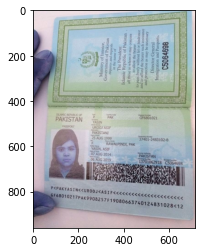

Augmented image: 
ColorJitter(brightness=None, contrast=None, saturation=None, hue=None)


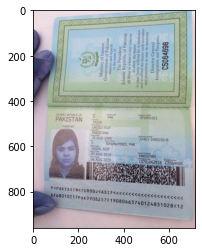

RandomPerspective(p=1.0)


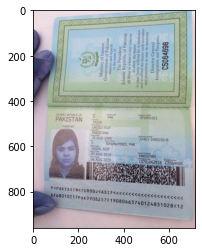

RandomAffine(degrees=[0.0, 0.0], shear=[-0.1, 0.1])


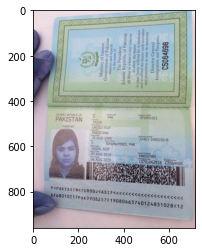

GaussianBlur(kernel_size=(7, 7), sigma=(0.1, 2.0))


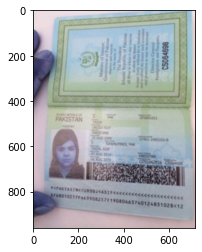

RandomRotation(degrees=[30.0, 30.0], resample=False, expand=False)


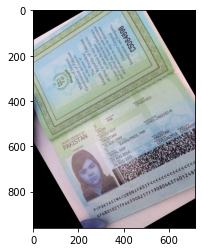

In [ ]:
print("Original image: ")
img = cv2.imread('/content/drive/MyDrive/DS Project/Original Dataset/train/Passport_PK/26.jpg')
plt.imshow(img)
plt.show()

print("Augmented image: ")
for i in range(5):
    img = cv2.imread(f"/content/drive/MyDrive/DS Project/Original Dataset/train/Passport_PK/{102+i}.jpg")
    print(augmentations[i])
    plt.imshow(img)
    plt.show()
    sleep(1)

**Data loading for classification**

In [ ]:
data_dir = '/content/drive/MyDrive/DS Project/Original Dataset'
batch_size = 16

def pil_loader(path, mode="RGB"):
    with open(path, "rb") as f:
        img = Image.open(f)
        return img.convert(mode)

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
print("Train Set: ", len(image_datasets['train']))
print("Val Set: ", len(image_datasets['val']))

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}


Train Set:  1194
Val Set:  20


In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode. 

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            if phase == 'train':
                scheduler.step()
            
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

**Defining Resenet18**

In [ ]:
# defining resnet18 for 4 classes

model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 4)

model_ft = model_ft.to(device)
summary(model_ft, (3, x, y))

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 10 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)

EPOCHS = 1

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 64, 128, 64]           9,408
       BatchNorm2d-2          [-1, 64, 128, 64]             128
              ReLU-3          [-1, 64, 128, 64]               0
         MaxPool2d-4           [-1, 64, 64, 32]               0
            Conv2d-5           [-1, 64, 64, 32]          36,864
       BatchNorm2d-6           [-1, 64, 64, 32]             128
              ReLU-7           [-1, 64, 64, 32]               0
            Conv2d-8           [-1, 64, 64, 32]          36,864
       BatchNorm2d-9           [-1, 64, 64, 32]             128
             ReLU-10           [-1, 64, 64, 32]               0
       BasicBlock-11           [-1, 64, 64, 32]               0
           Conv2d-12           [-1, 64, 64, 32]          36,864
      BatchNorm2d-13           [-1, 64, 64, 32]             128
             ReLU-14           [-1, 64,

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=EPOCHS)

Epoch 0/0
----------


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.4306 Acc: 0.8693
val Loss: 0.7909 Acc: 0.7000

Training complete in 1m 40s
Best val Acc: 0.700000


# Field detection within a card

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import time
import os
import copy
import random
import cv2
import pandas as pd
import json

from __future__ import print_function
from __future__ import division
from torchvision import datasets, models, transforms
from IPython.display import clear_output
from time import sleep
from PIL import Image
from torch.optim import lr_scheduler
from torchvision.datasets.folder import pil_loader
from torch.utils.data import Dataset
from torchsummary import summary
from google.colab.patches import cv2_imshow 

%matplotlib inline 
plt.ion()
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.7.0+cu101
Torchvision Version:  0.8.1+cu101


In [ ]:
%%shell

pip install cython
# Install pycocotools, the version by default in Colab
# has a bug fixed in https://github.com/cocodataset/cocoapi/pull/354
pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-7l_65lby
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-7l_65lby
  Created wheel for pycocotools: filename=pycocotools-2.0-cp36-cp36m-linux_x86_64.whl size=266459 sha256=7964d0a0a6f39078c7b2a542b4c932d6d3a3c92191aef6d4538addbe4888b472
  Stored in directory: /tmp/pip-ephem-wheel-cache-5q5quobn/wheels/90/51/41/646daf401c3bc408ff10de34ec76587a9b3ebfac8d21ca5c3a
Successfully built pycocotools
  Found existing installation: pycocotools 2.0
    Uninstalling pycocotools-2.0:
      Successfully uninstalled pycocotools-2.0


In [ ]:
!git clone "https://github.com/Paperspace/DataAugmentationForObjectDetection.git"
!cp -r "/content/DataAugmentationForObjectDetection/data_aug" "/content/"

fatal: destination path 'DataAugmentationForObjectDetection' already exists and is not an empty directory.


In [ ]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

fatal: destination path 'vision' already exists and is not an empty directory.
HEAD is now at be37608 version check against PyTorch's CUDA version


**Dataset class**

In [ ]:
from data_aug.data_aug import *
from data_aug.bbox_util import *
IMAGE_SIZE = 608
class CardFieldsDetection(Dataset):
    def __init__(self, data_path, csv_path, is_Train = True, transform=None):
        self.data = []
        self.annotations = []
        self.obj_labels = []
        self.masks = []
        self.transform = transform
         
        class_name = data_path.split("/")[-1]
        aug_root = "/content/drive/MyDrive/DS Project/Augmented Dataset"
        aug_path = os.path.join(aug_root, class_name)
        aug_image_id = 102

        labels_1_50 = pd.read_csv(os.path.join(csv_path,"labeled_1_50.csv"))
        labels_51_101 = pd.read_csv(os.path.join(csv_path,"labeled_51_101.csv"))

        labels_1_50['region_shape_attributes'] = labels_1_50['region_shape_attributes'].apply(lambda x: json.loads(x))
        labels_51_101['region_shape_attributes'] = labels_51_101['region_shape_attributes'].apply(lambda x: json.loads(x))


        for filename in os.listdir(data_path):
            image_id = int(filename.split(".")[0])
            image_path = os.path.join(data_path, filename)

            if image_id < 102:
                # find annotation of original image in csv
                if image_id < 51:
                    region_attributes = labels_1_50[labels_1_50.filename == filename]['region_shape_attributes']
                elif 51 <= image_id <= 101:
                    region_attributes = labels_51_101[labels_51_101.filename == filename]['region_shape_attributes'] 
                
                img = cv2.imread(image_path)[:,:,::-1] #OpenCV uses BGR channels

                height, width, channels = img.shape

                # convert annotations to xmin xman ymin ymax format
                annotation = []
                for idx, item in enumerate(region_attributes):
                    x1 = item['x']
                    x2 = x1 + item['width']

                    y1 = item['y']
                    y2 = y1 + item['height']

                    annotation.append([x1, y1, x2, y2, idx+1])  

                if len(annotation) == 0:
                    continue

                resizer = Resize(IMAGE_SIZE)
                img, annotation = resizer(img, np.array(annotation, dtype='float'))

                path = aug_path + f"/{image_id}.jpg" if is_Train else aug_root + f"/val/{image_id}.jpg"
                cv2.imwrite(path, img)

                # plotted_img = draw_rect(img, np.array(annotation))
                # plt.imshow(plotted_img)
                # plt.show()
                # sleep(1)

                self.data.append(path)
                self.annotations.append([x[:-1] for x in annotation])
                self.obj_labels.append([x[-1] for x in annotation])

                if is_Train:
                    # create augmented images and their augmented annotations
                    transforms = [
                                    RandomHorizontalFlip(1), 
                                    RandomScale(0.3, diff = True), 
                                    RandomTranslate(0.3, diff = True),
                                    RandomRotate(30), RandomRotate(60), RandomRotate(90), RandomRotate(120),
                                    RandomShear(0.2),
                                    RandomHSV(100, 100, 100),
                                ]
                   
                    for transform in transforms:
                        aug_image_path = aug_path + f"/{aug_image_id}.jpg"
                        aug_image_id += 1
                        annotation = np.array(annotation, dtype='float')

                        aug_img, aug_annotation = transform(img.copy(), annotation.copy())
                        # plotted_img = draw_rect(aug_img, aug_annotation)
                        # plt.imshow(plotted_img)
                        # plt.show()
                        # sleep(1)
                        try:
                            cv2.imwrite(aug_image_path, aug_img)
                            self.data.append(aug_image_path)
                            self.annotations.append([x[:-1] for x in aug_annotation])
                            self.obj_labels.append([x[-1] for x in aug_annotation])
                            
                        except:
                            continue
  
        print(f"[DatasetLoader/__init__] {len(self.data)} images.")

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path, annotation, obj_labels = self.data[idx], self.annotations[idx], self.obj_labels[idx]
        N = len(obj_labels)

        image = Image.open(img_path).convert("RGB")
        w, h = image.size

        image_id = torch.tensor([idx])
        labels = torch.as_tensor(obj_labels, dtype=torch.int64)
        boxes = torch.as_tensor(annotation, dtype=torch.float32)
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((N,), dtype=torch.int64)
        masks = torch.zeros((N, h, w), dtype=torch.uint8)

        for i, box in enumerate(np.array(annotation, dtype='int32')):
            row_s, row_e = box[1], box[3]
            col_s, col_e = box[0], box[2]
            masks[i, row_s:row_e, col_s:col_e] = 1

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd        

        if self.transform is not None:
            image, target = self.transform(image, target)
        return image, target

    def __len__(self):
        return len(self.data)


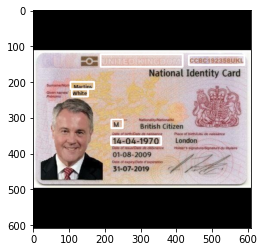

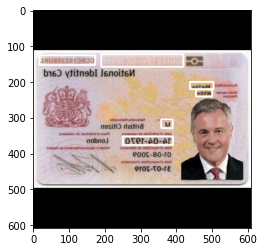

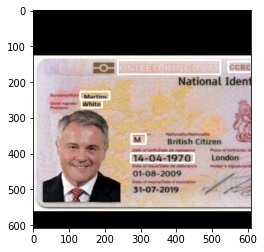

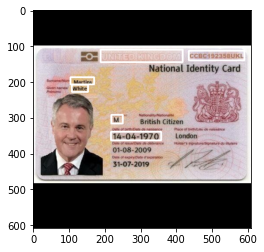

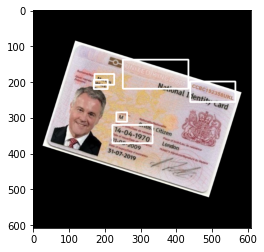

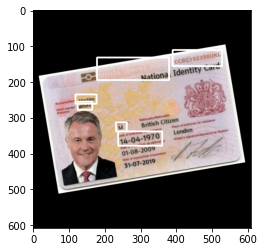

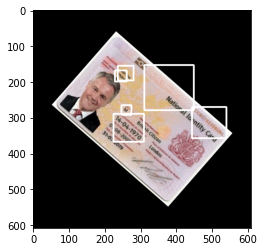

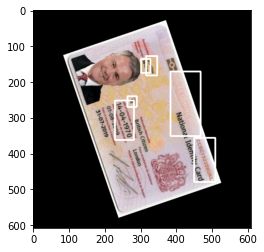

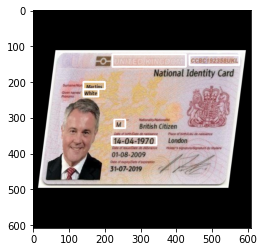

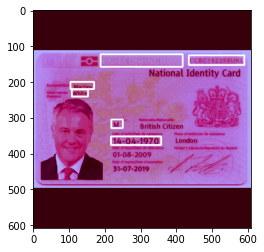

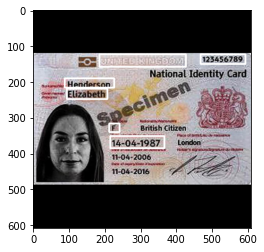

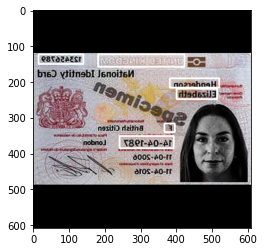

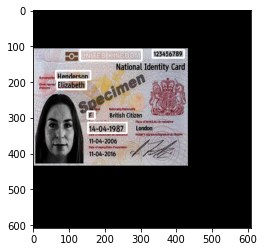

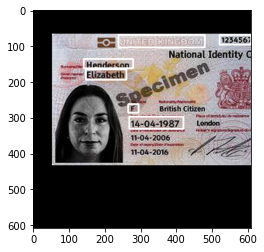

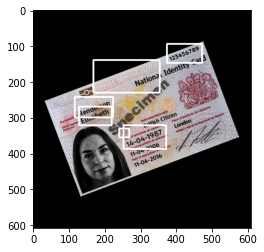

KeyboardInterrupt: ignored

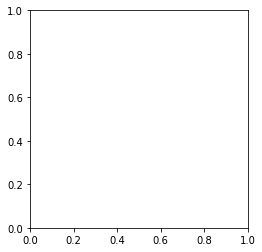

In [ ]:
# use our dataset and defined transformations
dataset = CardFieldsDetection('/content/drive/MyDrive/DS Project/Original Dataset/train/CNIC_UK', '/content/drive/MyDrive/DS Project/Annotated Dataset',
                                is_Train=True, transform=get_transform(train=True))
dataset_test = CardFieldsDetection('/content/drive/MyDrive/DS Project/Original Dataset/val/CNIC_UK', '/content/drive/MyDrive/DS Project/Annotated Dataset', 
                                is_Train=False, transform=get_transform(train=False))

print("Train Set: ", len(dataset))
print("Val Set: ", len(dataset_test))

In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [ ]:
import transforms as T
import utils

def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    return T.Compose(transforms)

# model = get_model_instance_segmentation(6+1)
# dataset = CardFieldsDetection('/content/drive/MyDrive/DS Project/Original Dataset/train/CNIC_PK', '/content/drive/MyDrive/DS Project/Annotated Dataset',is_Train=True, transform=get_transform(train=True))
# data_loader = torch.utils.data.DataLoader(dataset, batch_size=2, shuffle=True, num_workers=4, collate_fn=utils.collate_fn)
# # For Training
# images, targets = next(iter(data_loader))
# images = list(image for image in images)
# targets = [{k: v for k, v in t.items()} for t in targets]
# output = model(images,targets)   # Returns losses and detections
# print(output)
# # For inference
# model.eval()
# x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
# predictions = model(x)           # Returns predictions
# print(predictions)

In [ ]:
from engine import train_one_epoch, evaluate
import utils


# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 6+1
# use our dataset and defined transformations
dataset = CardFieldsDetection('/content/drive/MyDrive/DS Project/Original Dataset/train/CNIC_UK', '/content/drive/MyDrive/DS Project/Annotated Dataset',
                                is_Train=True, transform=get_transform(train=True))
dataset_test = CardFieldsDetection('/content/drive/MyDrive/DS Project/Original Dataset/val/CNIC_UK', '/content/drive/MyDrive/DS Project/Annotated Dataset', 
                                is_Train=False, transform=get_transform(train=False))

print("Train Set: ", len(dataset))
print("Val Set: ", len(dataset_test))

# # split the dataset in train and test set
# indices = torch.randperm(len(dataset)).tolist()
# dataset = torch.utils.data.Subset(dataset, indices[:-50])
# dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=8, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=4, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

# get the model using our helper function
model = get_model_instance_segmentation(num_classes)

# move model to the right device
model.to(device)


# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)
# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                step_size=3,
                                                gamma=0.1)

# let's train it for 10 epochs
num_epochs = 10

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

print("That's it!")


[DatasetLoader/__init__] 180 images.
[DatasetLoader/__init__] 5 images.
Train Set:  180
Val Set:  5


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


Epoch: [0]  [ 0/23]  eta: 0:01:03  lr: 0.000232  loss: 7.6301 (7.6301)  loss_classifier: 1.8694 (1.8694)  loss_box_reg: 0.0684 (0.0684)  loss_mask: 2.1923 (2.1923)  loss_objectness: 3.2948 (3.2948)  loss_rpn_box_reg: 0.2052 (0.2052)  time: 2.7485  data: 1.0547  max mem: 5821
Epoch: [0]  [10/23]  eta: 0:00:23  lr: 0.002502  loss: 2.3592 (3.3745)  loss_classifier: 0.7717 (1.0186)  loss_box_reg: 0.2750 (0.2251)  loss_mask: 1.0997 (1.2450)  loss_objectness: 0.2065 (0.7988)  loss_rpn_box_reg: 0.0748 (0.0869)  time: 1.8149  data: 0.1198  max mem: 6100
Epoch: [0]  [20/23]  eta: 0:00:05  lr: 0.004773  loss: 1.7287 (2.4504)  loss_classifier: 0.4517 (0.7323)  loss_box_reg: 0.3040 (0.2664)  loss_mask: 0.5904 (0.8961)  loss_objectness: 0.1362 (0.4812)  loss_rpn_box_reg: 0.0601 (0.0744)  time: 1.7638  data: 0.0286  max mem: 6195
Epoch: [0]  [22/23]  eta: 0:00:01  lr: 0.005000  loss: 1.5513 (2.3657)  loss_classifier: 0.4346 (0.7069)  loss_box_reg: 0.3162 (0.2822)  loss_mask: 0.5498 (0.8589)  loss_ob

In [ ]:
def extract_bbox(prediction, threshold=0.5):
    required_bboxes = []
    for i in range(6):
        output_mask = prediction['labels'] == i+1       
        label_scores = prediction['scores'] * output_mask
        label_scores = label_scores >= threshold
        output_mask = output_mask.unsqueeze(-1).expand(prediction['boxes'].size())
        boxes = prediction['boxes'] * output_mask
        value, idx = torch.max(label_scores, dim=0)
        required_bboxes.append(boxes[idx].tolist())

    return required_bboxes


def predict_one(model, img_path):
    model.eval()
    transform = transforms.Compose([                      
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor()
    ])

    img = Image.open(img_path).convert("RGB")

    img = transform(img).to(device)
    prediction = model(img.view(1,3,IMAGE_SIZE,IMAGE_SIZE))
    
    return prediction[0]

**Testing trained model on a single image**

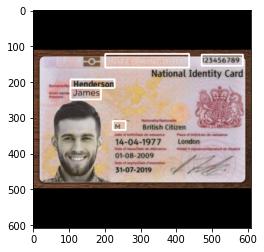

In [ ]:
test_image_path = '/content/drive/MyDrive/DS Project/Augmented Dataset/val/51.jpg'

prediction = predict_one(model,test_image_path)
bboxes = np.array(extract_bbox(prediction))
plotted_img = draw_rect(cv2.imread(test_image_path), bboxes)
plt.imshow(plotted_img)
plt.show()
sleep(1)